In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from astropy.coordinates import SkyCoord
from astropy import units as u

#### NGC 2516

In [2]:
df_all = pd.read_parquet('../data/nway_CSC21_GAIA3.parquet')

In [49]:
df_csc = pd.read_parquet('../data/csc_all.parquet')

In [50]:
# read vot to pandas ../data/all_stacks.vot
from astropy.io.votable import parse_single_table

# read vot to pandas
table = parse_single_table('../data/all_stacks.vot')

# recover column names
df_all_stacks = table.to_table().to_pandas()
df_all_stacks.columns = [col.name for col in table.fields]

In [51]:


# center of the region
center = SkyCoord('07h58m06.5s -60d48m00s', frame='icrs')

# create SkyCoord objects for all sources
source_coords = SkyCoord(ra=df_all['CSC21_RA'].values * u.deg, dec=df_all['CSC21_Dec'].values * u.deg, frame='icrs')

# calculate separations
separations = source_coords.separation(center)

# filter the dataframe
df_all['separation_from_ngc2516'] = separations.to(u.arcmin)
sources_in_region = df_all[separations <= 30 * u.arcmin]
cscid_list = sources_in_region['CSC21_CSCID'].str.replace('_', ' ').str.strip().unique().tolist()
sources_in_region['num_possible_counterparts'] = sources_in_region.groupby('CSC21_CSCID')['GAIA3_source_id'].transform('count')

print(cscid_list)


['2CXO J075629.6-605413', '2CXO J075634.8-604802', '2CXO J075646.3-604857', '2CXO J075646.8-604322', '2CXO J075647.4-605651', '2CXO J075648.3-604630', '2CXO J075706.2-604337', '2CXO J075711.2-603308', '2CXO J075714.2-604052', '2CXO J075716.6-604711', '2CXO J075718.3-604816', '2CXO J075719.0-605627', '2CXO J075719.7-604846', '2CXO J075720.8-604402', '2CXO J075723.2-604938', '2CXO J075724.2-603947', '2CXO J075725.2-604647', '2CXO J075725.3-604458', '2CXO J075726.1-604540', '2CXO J075726.8-603947', '2CXO J075728.4-605129', '2CXO J075729.2-604608', '2CXO J075729.4-605210', '2CXO J075729.5-603706', '2CXO J075730.7-604720', '2CXO J075730.9-604832', '2CXO J075732.7-604111', '2CXO J075736.1-604812', '2CXO J075736.1-605024', '2CXO J075737.5-605435', '2CXO J075739.5-604413', '2CXO J075739.8-604639', '2CXO J075742.7-604420', '2CXO J075742.8-604540', '2CXO J075743.2-604509', '2CXO J075743.5-604945', '2CXO J075744.0-604727', '2CXO J075746.0-604550', '2CXO J075746.0-604839', '2CXO J075747.0-604239',

/tmp/ipykernel_2042345/222764686.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sources_in_region['num_possible_counterparts'] = sources_in_region.groupby('CSC21_CSCID')['GAIA3_source_id'].transform('count')


In [52]:
sources_in_region['num_possible_counterparts']

627690    1
627691    1
627692    4
627693    4
627694    4
         ..
628079    2
628080    4
628081    4
628082    4
628083    4
Name: num_possible_counterparts, Length: 394, dtype: int64

In [53]:
matches = sources_in_region[sources_in_region['match_flag'] == 1]
ngc2516 = matches[['CSC21_CSCID', 'GAIA3_source_id', 'p_i', 'p_any', 'separation_from_ngc2516', 'num_possible_counterparts']]


In [54]:
ngc2516

,CSC21_CSCID,GAIA3_source_id,p_i,p_any,separation_from_ngc2516,num_possible_counterparts
627690,2CXO_J075629.6-605413,5290716602714076800,1.000000,8.556489e-12,13.332860,1
627691,2CXO_J075634.8-604802,5290723925638255104,1.000000,8.986671e-01,11.184249,1
627693,2CXO_J075646.3-604857,5290722929205920896,0.998133,9.436769e-01,9.826725,4
627698,2CXO_J075646.8-604322,5290736363863548032,1.000000,8.818952e-01,10.774503,3
627701,2CXO_J075647.4-605651,5290719115275116288,0.978879,6.866363e-01,13.082561,3
...,...,...,...,...,...,...
628069,2CXO_J075922.9-604731,5290767356348330496,1.000000,8.994326e-01,9.354922,3
628072,2CXO_J075931.9-604843,5290767115830162560,1.000000,9.527714e-01,10.445599,2
628077,2CXO_J075936.4-604432,5290769727171800320,1.000000,9.604923e-01,11.504419,4
628078,2CXO_J075946.0-605120,5290763812994440960,0.997136,6.223306e-01,12.584193,2


In [55]:
ambiguous_matches = ngc2516[(ngc2516['p_i'] < 0.9) & (ngc2516['num_possible_counterparts'] > 1)]
print(ambiguous_matches)

                   CSC21_CSCID      GAIA3_source_id       p_i     p_any  \
627705  2CXO_J075711.2-603308   5290739937276199168  0.771767  0.274922   
627724  2CXO_J075724.2-603947   5290738356724884096  0.646706  0.937957   
627735  2CXO_J075726.8-603947   5290726605692967936  0.721580  0.698412   
627839  2CXO_J075758.3-605247   5290673416818436480  0.527081  0.976085   
627847  2CXO_J075800.4-605212   5290720386585450240  0.714931  0.991267   
628051  2CXO_J075905.1-604429   5290768524579342976  0.801975  0.963219   

        separation_from_ngc2516  num_possible_counterparts  
627705                16.325483                          3  
627724                 9.698965                          3  
627735                 9.540890                          3  
627839                 4.898221                          4  
627847                 4.270515                          2  
628051                 7.976182                          7  


In [56]:
ambiguous_matches[['CSC21_CSCID', 'GAIA3_source_id', 'p_i', 'p_any']]

,CSC21_CSCID,GAIA3_source_id,p_i,p_any
627705,2CXO_J075711.2-603308,5290739937276199168,0.771767,0.274922
627724,2CXO_J075724.2-603947,5290738356724884096,0.646706,0.937957
627735,2CXO_J075726.8-603947,5290726605692967936,0.721580,0.698412
627839,2CXO_J075758.3-605247,5290673416818436480,0.527081,0.976085
627847,2CXO_J075800.4-605212,5290720386585450240,0.714931,0.991267
628051,2CXO_J075905.1-604429,5290768524579342976,0.801975,0.963219


----

In [57]:
from astropy.io import fits

# Read the FITS file
with fits.open('../data/J_ApJ_588_1009_table5.dat.fits') as hdul:
    data = hdul[1].data  # Assuming the data is in the first extension

# Convert to a pandas DataFrame
df_table5_fits = pd.DataFrame(data)

# Display the first few rows of the DataFrame
df_table5_fits.head()

FileNotFoundError: [Errno 2] No such file or directory: '../data/J_ApJ_588_1009_table5.dat.fits'

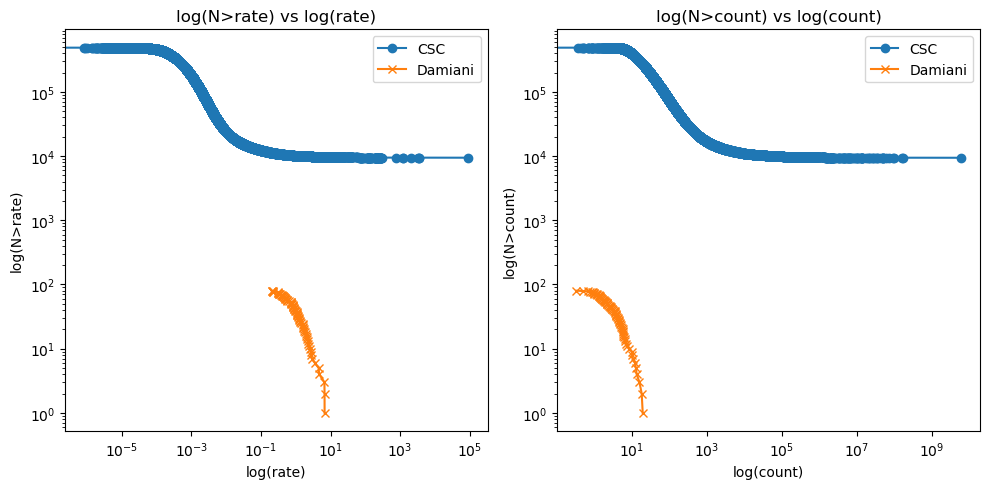

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Toy data for CSC and Damiani samples (replace with actual data)
# Rate and counts are made-up data for the toy sample
csc_rate = df_all_stacks.src_rate_aper_b # CSC rate values
csc_ct = df_all_stacks.src_cnts_aper_b   # CSC count values
damiani_rate = np.random.lognormal(mean=0, sigma=1, size=80)  # Damiani rate values
damiani_ct = np.random.lognormal(mean=1, sigma=1, size=80)    # Damiani count values

# Function to calculate cumulative N(rate > threshold) or N(ct > threshold)
def cumulative_count(data):
    sorted_data = np.sort(data)[::-1]  # Sort descending
    return np.arange(1, len(data)+1), sorted_data  # Return cumulative count and sorted data

# Calculate cumulative counts for rates
csc_N_rate, csc_sorted_rate = cumulative_count(csc_rate)
damiani_N_rate, damiani_sorted_rate = cumulative_count(damiani_rate)

# Calculate cumulative counts for counts
csc_N_ct, csc_sorted_ct = cumulative_count(csc_ct)
damiani_N_ct, damiani_sorted_ct = cumulative_count(damiani_ct)

# Plotting log(N>rate) vs log(rate)
plt.figure(figsize=(10, 5))

# CSC Rate plot
plt.subplot(1, 2, 1)
plt.loglog(csc_sorted_rate, csc_N_rate, label='CSC', marker='o')
plt.loglog(damiani_sorted_rate, damiani_N_rate, label='Damiani', marker='x')
plt.xlabel('log(rate)')
plt.ylabel('log(N>rate)')
plt.title('log(N>rate) vs log(rate)')
plt.legend()

# CSC Count plot
plt.subplot(1, 2, 2)
plt.loglog(csc_sorted_ct, csc_N_ct, label='CSC', marker='o')
plt.loglog(damiani_sorted_ct, damiani_N_ct, label='Damiani', marker='x')
plt.xlabel('log(count)')
plt.ylabel('log(N>count)')
plt.title('log(N>count) vs log(count)')
plt.legend()

plt.tight_layout()
plt.show()


--- 
#### Orion

In [2]:
df_all_model = pd.read_parquet('../scripts/nway_csc21_gaia3_full_neg_study_dis_niter200.parquet')

In [4]:
# Define the center of the Orion Nebula region
orion_center = SkyCoord(ra=83.8210 * u.deg, dec=-5.3944 * u.deg, frame='icrs')

# Create SkyCoord objects for all sources
orion_source_coords = SkyCoord(ra=df_all_model['CSC21_RA'].values * u.deg, dec=df_all_model['CSC21_Dec'].values * u.deg, frame='icrs')

# Calculate separations
orion_separations = orion_source_coords.separation(orion_center)

# Filter the dataframe
df_all['separation_from_orion'] = orion_separations.to(u.arcmin)
orion_sources_in_region = df_all[orion_separations <= 15 * u.arcmin]
orion_cscid_list = orion_sources_in_region['CSC21_CSCID'].str.replace('_', ' ').str.strip().unique().tolist()
orion_sources_in_region['num_possible_counterparts'] = orion_sources_in_region.groupby('CSC21_CSCID')['GAIA3_source_id'].transform('count')

print(orion_cscid_list)


KeyError: 'CSC21_RA'

In [74]:
len(orion_cscid_list)

1486

In [75]:
matches_orion = orion_sources_in_region[orion_sources_in_region['match_flag'] == 1]


In [76]:
df_orion_stack = df_all_stacks[df_all_stacks['name'].isin(orion_cscid_list)]

In [19]:
from astropy.io import fits

# Read the FITS file
with fits.open('../data/J_ApJS_160_319_table4.dat.fits') as hdul:
    data = hdul[1].data  # Assuming the data is in the first extension

# Convert to a pandas DataFrame
df_apj = pd.DataFrame(data)

# Display the first few rows of the DataFrame
df_apj.head()

,COUP,Name,SrcCts,BkgCts,NetCts,ExtArea,PSFFrac,ExpTime,CtFlConv,Xflux,<E>,HR1,e_HR1,E_HR1,HR2,e_HR2,E_HR2,HR3,e_HR3,E_HR3
0,1,053429.4-052337,883,89,793,664,0.50,500.4,0.283,-4.897,1.28,-0.59,0.04,0.04,-0.54,0.03,0.04,-0.34,0.08,0.08
1,2,053429.5-052354,1884,53,1830,1245,0.68,157.4,0.089,-4.308,1.19,-0.69,0.02,0.02,-0.67,0.02,0.02,-0.28,0.05,0.05
2,3,053433.9-052211,148,132,15,1541,0.89,382.0,0.216,-6.737,0.88,-1.00,0.00,0.60,-1.00,0.00,0.40,0.00,0.00,0.00
3,4,053434.9-052507,327,310,16,1678,0.89,527.0,0.298,-6.986,5.02,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
4,5,053438.2-052338,139,70,68,396,0.69,740.9,0.419,-6.292,4.69,0.75,0.20,0.19,-0.22,0.88,0.45,0.81,0.16,0.17


In [22]:
# Calculate the rate
df_apj['Rate'] = df_apj['NetCts'] / (df_apj['ExpTime'] *1000)

# Display the DataFrame with the new Rate column
print(df_apj)

      COUP              Name  SrcCts  BkgCts  NetCts  ExtArea  PSFFrac  \
0        1  053429.4-052337      883      89     793      664     0.50   
1        2  053429.5-052354     1884      53    1830     1245     0.68   
2        3  053433.9-052211      148     132      15     1541     0.89   
3        4  053434.9-052507      327     310      16     1678     0.89   
4        5  053438.2-052338      139      70      68      396     0.69   
...    ...               ...     ...     ...     ...      ...      ...   
1611  1612  053555.4-052342     1128     152     975      969     0.89   
1612  1613  053556.8-052527      180     141      38     1062     0.88   
1613  1614  053557.3-052508      398     148     249     1091     0.88   
1614  1615  053557.4-052415      336     184     151     1165     0.89   
1615  1616  053557.6-052310      562     109     452     1238     0.83   

      ExpTime  CtFlConv  Xflux  ...   HR1  e_HR1  E_HR1   HR2  e_HR2  E_HR2  \
0       500.4     0.283 -4.897  

In [23]:
df_apj['Rate']

0       0.001585
1       0.011626
2       0.000039
3       0.000030
4       0.000092
          ...   
1611    0.001494
1612    0.000059
1613    0.000358
1614    0.000233
1615    0.001578
Name: Rate, Length: 1616, dtype: float64

In [28]:
csc_rate= df_orion_stack.src_rate_aper_b
csc_ct = df_orion_stack.src_cnts_aper_b
apj_rate = df_apj['Rate']
apj_counts = df_apj['NetCts']

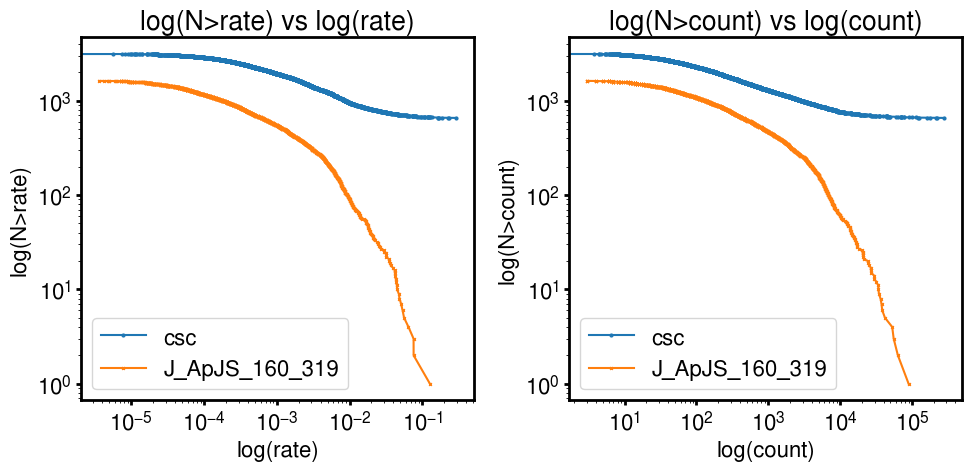

In [38]:
plt.rcParams['font.family'] = 'Nimbus Sans'
plt.rcParams['font.size'] = 16  # Increased from 12
plt.rcParams['axes.linewidth'] = 2  # Increased from 1.5
plt.rcParams['xtick.major.width'] = 2  # Increased from 1.5
plt.rcParams['ytick.major.width'] = 2  # Increased from 1.5

# calculate cumulative counts for rates
csc_N_rate, csc_sorted_rate = cumulative_count(csc_rate)
apj_N_rate, apj_sorted_rate = cumulative_count(apj_rate)

# calculate cumulative counts for counts
csc_N_ct, csc_sorted_ct = cumulative_count(csc_ct)
apj_N_ct, apj_sorted_ct = cumulative_count(apj_counts)

# plotting log(N>rate) vs log(rate)
plt.figure(figsize=(10, 5))

# csc rate plot
plt.subplot(1, 2, 1)
plt.loglog(csc_sorted_rate, csc_N_rate, label='csc', marker='o', markersize=2)
plt.loglog(apj_sorted_rate, apj_N_rate, label='J_ApJS_160_319', marker='x', markersize=2)
plt.xlabel('log(rate)')
plt.ylabel('log(N>rate)')
plt.title('log(N>rate) vs log(rate)')
plt.legend()

# csc count plot
plt.subplot(1, 2, 2)
plt.loglog(csc_sorted_ct, csc_N_ct, label='csc', marker='o', markersize=2)
plt.loglog(apj_sorted_ct, apj_N_ct, label='J_ApJS_160_319', marker='x', markersize=2)
plt.xlabel('log(count)')
plt.ylabel('log(N>count)')
plt.title('log(N>count) vs log(count)')
plt.legend()

plt.tight_layout()
plt.show()


In [67]:
df_apj

,COUP,Name,SrcCts,BkgCts,NetCts,ExtArea,PSFFrac,ExpTime,CtFlConv,Xflux,...,HR1,e_HR1,E_HR1,HR2,e_HR2,E_HR2,HR3,e_HR3,E_HR3,Rate
0,1,053429.4-052337,883,89,793,664,0.50,500.4,0.283,-4.897,...,-0.59,0.04,0.04,-0.54,0.03,0.04,-0.34,0.08,0.08,0.001585
1,2,053429.5-052354,1884,53,1830,1245,0.68,157.4,0.089,-4.308,...,-0.69,0.02,0.02,-0.67,0.02,0.02,-0.28,0.05,0.05,0.011626
2,3,053433.9-052211,148,132,15,1541,0.89,382.0,0.216,-6.737,...,-1.00,0.00,0.60,-1.00,0.00,0.40,0.00,0.00,0.00,0.000039
3,4,053434.9-052507,327,310,16,1678,0.89,527.0,0.298,-6.986,...,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.000030
4,5,053438.2-052338,139,70,68,396,0.69,740.9,0.419,-6.292,...,0.75,0.20,0.19,-0.22,0.88,0.45,0.81,0.16,0.17,0.000092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1611,1612,053555.4-052342,1128,152,975,969,0.89,652.5,0.369,-5.208,...,-0.80,0.04,0.04,-0.73,0.03,0.03,-0.38,0.16,0.15,0.001494
1612,1613,053556.8-052527,180,141,38,1062,0.88,649.0,0.367,-6.605,...,-1.00,0.00,0.60,-1.00,0.00,0.41,0.00,0.00,0.00,0.000059
1613,1614,053557.3-052508,398,148,249,1091,0.88,695.0,0.393,-5.816,...,-0.90,0.00,0.14,-0.88,0.09,0.10,-0.61,0.00,0.83,0.000358
1614,1615,053557.4-052415,336,184,151,1165,0.89,649.0,0.367,-6.007,...,0.61,0.18,0.17,0.47,0.52,0.37,0.46,0.17,0.16,0.000233


In [68]:
# Read the FITS file
with fits.open('../data/J_ApJS_160_319_table2.dat.fits') as hdul:
    data = hdul[1].data  # Assuming the data is in the first extension

# Convert to a pandas DataFrame
df_apj_2 = pd.DataFrame(data)

# Display the first few rows of the DataFrame
df_apj_2.head()

,COUP,Name,RAdeg,DEdeg,PosErr,Offaxis,Flags,Fl1,Fl2,M1,M2,M3,SigAE,SigPWD,ACIS,HRC
0,1,053429.4-052337,83.622730,-5.393730,0.16,11.85,-d---x,1,1,1,1,0,23.9,36.0,0,0
1,2,053429.5-052354,83.623040,-5.398490,0.11,11.83,-d---x,1,1,1,1,0,41.0,94.4,0,10
2,3,053433.9-052211,83.641473,-5.369767,0.59,10.83,-----x,1,0,1,0,0,0.6,0.0,0,0
3,4,053434.9-052507,83.645653,-5.418817,0.38,10.58,-----x,1,0,1,0,0,0.5,0.0,0,0
4,5,053438.2-052338,83.659339,-5.393952,0.35,9.66,------,1,1,1,1,0,4.0,7.0,0,0


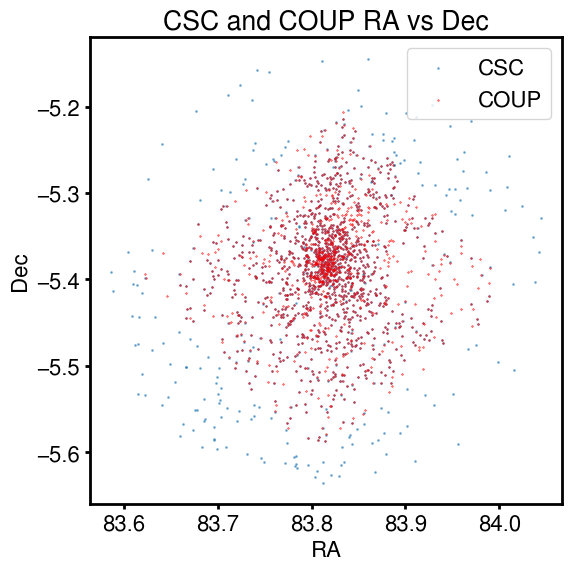

In [77]:
# Scatter plot for CSC and COUP data on the same axis
plt.figure(figsize=(6, 6))

plt.scatter(matches_orion['CSC21_RA'], matches_orion['CSC21_Dec'], s=1, alpha=0.5, label='CSC', marker='o')
plt.scatter(df_apj_2['RAdeg'], df_apj_2['DEdeg'], s=1, alpha=0.5, label='COUP', color='red', marker='x')

plt.xlabel('RA')
plt.ylabel('Dec')
plt.title('CSC and COUP RA vs Dec')
plt.legend()

plt.tight_layout()
plt.show()


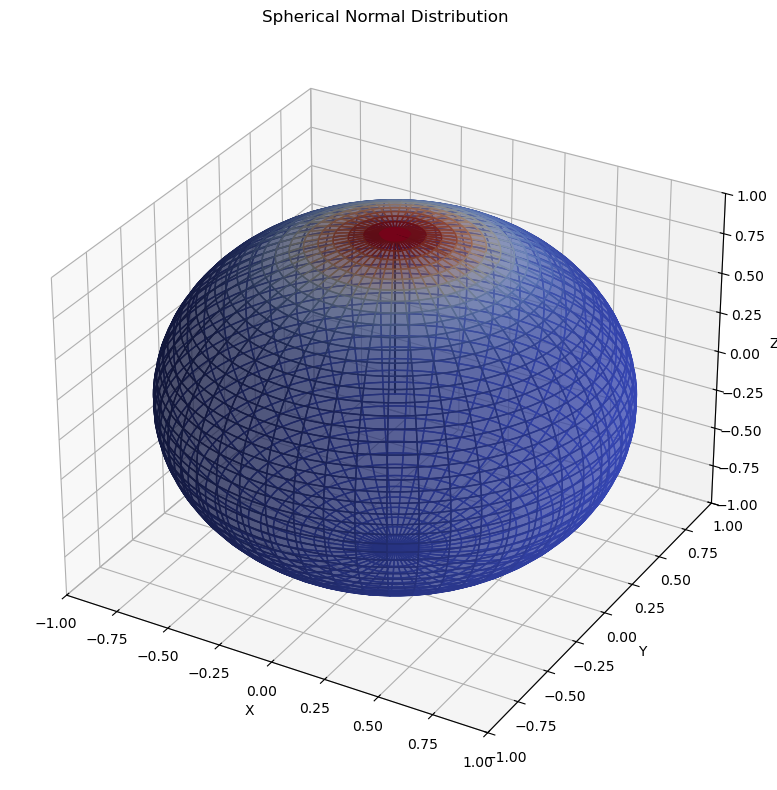

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def spherical_normal(x, mu, kappa):
    # Perform the dot product along the first axis
    dot_product = np.tensordot(mu, x, axes=(0, 0))
    return kappa / (4 * np.pi * np.sinh(kappa)) * np.exp(kappa * dot_product)

# Generate points on a 3D grid
phi = np.linspace(0, 2 * np.pi, 100)
theta = np.linspace(0, np.pi, 100)
phi, theta = np.meshgrid(phi, theta)

# Convert spherical coordinates to Cartesian coordinates
x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)

# Define the mean direction and concentration parameter
mu = np.array([0, 0, 1])  # mean direction (pointing up)
kappa = 10  # concentration parameter

# Calculate the spherical normal distribution
pdf = spherical_normal(np.array([x, y, z]), mu, kappa)

# Create a 3D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the distribution on the sphere
ax.plot_surface(x, y, z, facecolors=cm.coolwarm(pdf/pdf.max()), alpha=0.5)

# Plot the mean direction
ax.quiver(0, 0, 0, mu[0], mu[1], mu[2], length=1, arrow_length_ratio=0.1, color='black')

# Format the plot
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Spherical Normal Distribution')

plt.tight_layout()
plt.show()

In [90]:
import numpy as np

# Define the positions and positional uncertainties of the sources
ra_A, dec_A = 30.0, 30.0  # position of source in catalog A (in degrees)
ra_B, dec_B = 30.1, 30.2  # position of source in catalog B (in degrees)
sigma_A = 0.1  # positional uncertainty of source in catalog A (in degrees)
sigma_B = 0.2  # positional uncertainty of source in catalog B (in degrees)

# Calculate the separation between the sources
separation = np.sqrt((ra_A - ra_B)**2 + (dec_A - dec_B)**2)

# Calculate P(D|H_associated)
P_D_given_H_associated = (1 / (2 * np.pi * sigma_A * sigma_B)) * np.exp(-separation**2 / (2 * (sigma_A**2 + sigma_B**2)))

# Calculate P(D|H_unrelated)
# Let's assume a number density of 0.001 sources per square degree in catalog B
number_density_B = 0.001
P_D_given_H_unrelated = number_density_B

# Calculate the Bayes factor
bayes_factor = P_D_given_H_associated / P_D_given_H_unrelated

print(f"Separation: {separation:.3f} degrees")
print(f"P(D|H_associated): {P_D_given_H_associated:.5f}")
print(f"P(D|H_unrelated): {P_D_given_H_unrelated:.5f}")
print(f"Bayes factor: {bayes_factor:.2f}")

Separation: 0.224 degrees
P(D|H_associated): 4.82662
P(D|H_unrelated): 0.00100
Bayes factor: 4826.62
